<a href="https://colab.research.google.com/github/bora-arda/ImageCaptioning/blob/main/imageCaptionGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm
import re
import cv2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import hog
import matplotlib.pyplot as plt

In [1]:
!pip install -U datasets

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Kaggle API upload
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle competitions download obss-intern-competition-2025
!unzip obss-intern-competition-2025.zip
!rm -r obss-intern-competition-2025.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: train/train/5499.jpg    
  inflating: train/train/55.jpg      
  inflating: train/train/550.jpg     
  inflating: train/train/5500.jpg    
  inflating: train/train/5501.jpg    
  inflating: train/train/5502.jpg    
  inflating: train/train/5503.jpg    
  inflating: train/train/5504.jpg    
  inflating: train/train/5505.jpg    
  inflating: train/train/5506.jpg    
  inflating: train/train/5507.jpg    
  inflating: train/train/5508.jpg    
  inflating: train/train/5509.jpg    
  inflating: train/train/551.jpg     
  inflating: train/train/5510.jpg    
  inflating: train/train/5511.jpg    
  inflating: train/train/5512.jpg    
  inflating: train/train/5513.jpg    
  inflating: train/train/5514.jpg    
  inflating: train/train/5515.jpg    
  inflating: train/train/5516.jpg    
  inflating: train/train/5517.jpg    
  inflating: train/train/5518.jpg    
  inflating: train/train/5519.jpg    
  inflating: train/train/552.jpg     
  i

In [3]:
from datasets import Dataset

dataset = load_dataset(
    "csv",
    data_files={
        "train": "train.csv",
        "test": "test.csv"
    }
)

print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'caption'],
        num_rows: 21367
    })
    test: Dataset({
        features: ['image_id', 'caption'],
        num_rows: 3771
    })
})


In [4]:
class Tokenizer():
  def __init__(self, caption_list, min_freq = 1, max_len = 35):
    self.max_len = max_len
    self.min_freq = min_freq
    # self.word2idx = {}
    # self.idx2word = {}

    self.pad_token = '<PAD>'
    self.start_token = '<START>'
    self.end_token = '<END>'
    self.unk_token = '<UNK>'
    self.special_tokens = [self.start_token, self.end_token, self.pad_token, self.unk_token]

    self.build_vocab(caption_list)

  def build_vocab(self, caption_list):
    token_counts = set()
    for caption in caption_list:
      tokens = self.tokenize(caption)
      token_counts.update(tokens)

    vocab_tokens = [token for token in token_counts if len(token) >= 1]
    vocab_tokens = self.special_tokens + sorted(set(vocab_tokens))

    self.word2idx = {word: idx for idx, word in enumerate(vocab_tokens)}
    self.idx2word = {idx: word for word, idx in self.word2idx.items()}

  def tokenize(self, text):
    return text.lower().split()


  def encode(self, caption):
    tokens = [self.start_token] + self.tokenize(caption) + [self.end_token]
    token_ids = [self.word2idx.get(t, self.word2idx[self.unk_token]) for t in tokens]

    if len(token_ids) < self.max_len:
      token_ids += [self.word2idx[self.pad_token]] * (self.max_len - len(token_ids))
    else:
      token_ids = token_ids[:self.max_len]

    return token_ids

  def decode(self, token_ids):
    tokens = [self.idx2word.get(idx, self.unk_token) for idx in token_ids]

    if self.end_token in tokens:
      end_idx = tokens.index(self.end_token) + 1
      tokens = tokens[:end_idx]
    tokens = [t for t in tokens if t not in [self.pad_token]]
    return " ".join(tokens)

  def vocab_size(self):
    return len(self.word2idx)

In [5]:
def extractHogFeatures(image_path):
  image = cv2.imread(image_path, 0)

  # Resize the image
  resized_image = resize(image, (128*2, 128*2))

  # Gray scaling
  # gray_image = rgb2gray(resized_image)

  features, hog_image = hog(
      resized_image,
      orientations = 9,
      pixels_per_cell = (8, 8),
      cells_per_block = (2,2),
      block_norm = 'L2-Hys',
      visualize = True,
      feature_vector = True)
  return features, hog_image

In [7]:
tokenizer = Tokenizer(dataset["train"][:500]["caption"])
caption_list = dataset['train'][:500]['caption']

ids = [tokenizer.encode(caption) for caption in caption_list]
decoded = [tokenizer.decode(id) for id in ids]
tensor_ids = torch.tensor(ids).unsqueeze(0)
embedding = nn.Embedding(num_embeddings=tokenizer.vocab_size(), embedding_dim = 50)
embedded_ids = embedding(tensor_ids[:, :-1])
print(f"Captions: {caption_list}")
print(f"Token IDs: {ids}")
print(f"Decoded: {decoded}")
print(f"Length: {tokenizer.vocab_size()}")
print(f"Shape: {len(ids)}")
print(f"Tensor IDs: {tensor_ids}")
print(f"Embedding: {embedded_ids.shape}")

Captions: ['The image features a comic-style panel depicting a scene from a story, with dialogue and narration above.', 'Colorful postcard featuring "Greetings from Cherry Grove Beach, S.C." with images of beach scenes and vibrant lettering.', 'Two vending machines display a variety of drinks, illuminated with colorful lights, in a train station setting.', 'A man speaks at the eGovernment Conference 2013, with multiple logos displayed on computer monitors behind him.', 'A close-up of several silver coins stacked together, showcasing their shiny surfaces and engraved designs.', 'A woman speaking at a podium, surrounded by seated officials, with a building and event branding in the background.', 'A black iPhone and a Samsung smartphone are displayed side by side on a wooden surface, showcasing their home screens.', 'The image features a presentation event with a speaker at a microphone, a woman beside him, and a display of posters in the background.', 'A bottle of Phillips Brewing Compan

In [8]:
class CaptionDataset(torch.utils.data.Dataset):
  def __init__(self, csv_data, image_dir, tokenizer, transform=None):
    self.image_ids = csv_data['image_id']
    self.captions = csv_data['caption']
    self.image_dir = image_dir
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    # Load image and extract HOG features
    image_path = f"{self.image_dir}/{self.image_ids[idx]}.jpg"
    hog_features, _ = extractHogFeatures(image_path)

    # Tokenize caption
    caption_tokens = self.tokenizer.encode(self.captions[idx])

    # Create input (without last token) and target (without first token)
    input_seq = caption_tokens[:-1] # [START, word1, word2, ...]
    target_seq = caption_tokens[1:] # [word1, word2, ..., END]

    return {
        'hog_features': torch.tensor(hog_features, dtype=torch.float32),
        'input_seq': torch.tensor(input_seq, dtype = torch.long),
        'target_seq': torch.tensor(target_seq, dtype = torch.long)
    }

In [9]:
class LSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_size, vocab_size, hog_dim, num_layers=2):
    super(LSTM, self).__init__()
    self.num_layers = num_layers
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.hog_to_h0 = nn.Linear(hog_dim, hidden_size)
    self.hog_to_c0 = nn.Linear(hog_dim, hidden_size)


    self.lstm = nn.LSTM(input_size = embedding_dim,
                        hidden_size = hidden_size,
                        num_layers = num_layers,
                        batch_first = True)

    self.fc_out = nn.Linear(hidden_size, vocab_size)


  def forward(self, input_seq, hog_features):
    embeddings = self.embedding(input_seq)

    h0 = self.hog_to_h0(hog_features)
    h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
    c0 = self.hog_to_c0(hog_features)
    c0 = c0.unsqueeze(0).repeat(self.num_layers, 1, 1)

    lstm_out, _ = self.lstm(embeddings, (h0, c0))
    outputs = self.fc_out(lstm_out)
    return outputs

In [10]:
def collate_fn(batch):
    """Custom collate function to handle variable-length sequences"""
    hog_features = torch.stack([item['hog_features'] for item in batch])
    input_seqs = torch.stack([item['input_seq'] for item in batch])
    target_seqs = torch.stack([item['target_seq'] for item in batch])

    return {
        'hog_features': hog_features,
        'input_seqs': input_seqs,
        'target_seqs': target_seqs
    }

# Create datasets
train_dataset = CaptionDataset(dataset['train'], './train/train', tokenizer)
# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=8,
#     shuffle=True,
#     collate_fn=collate_fn
# )


In [11]:
def train_model(model, train_loader, num_epochs = 10):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)

  criterion = nn.CrossEntropyLoss(ignore_index = tokenizer.word2idx['<PAD>'])
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

  model.train()
  for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, batch in enumerate(train_loader):
      hog_features = batch['hog_features'].to(device)
      input_seqs = batch['input_seqs'].to(device)
      target_seqs = batch['target_seqs'].to(device)

      optimizer.zero_grad()
      outputs = model(input_seqs, hog_features)

      # Calculate loss
      # Reshape for loss calculation
      loss = criterion(
          outputs.reshape(-1, outputs.size(-1)),
          target_seqs.reshape(-1)
      )

      # Backward pass
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

      if batch_idx % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

    print(f"Epoch {epoch} completed, Average loss: {total_loss/len(train_loader):.4f}")
  return model

In [12]:
def save_model(model, tokenizer, path = 'caption_model.pth'):
  torch.save({
      'model_state_dict': model.state_dict(),
      'tokenizer': tokenizer,
      'vocab_size': tokenizer.vocab_size(),
  }, path)

def load_model(path, embedding_dim, hidden_size, hog_dim):
  checkpoint = torch.load(path)
  tokenizer = checkpoint['tokenizer']

  model = LSTM(embedding_dim, hidden_size, checkpoint['vocab_size'], hog_dim)
  model.load_state_dict(checkpoint['model_state_dict'])

  return model, tokenizer

In [13]:
def validate_model(model, val_loader):
  model.eval()
  total_loss = 0
  criterion = nn.CrossEntropyLoss(ignore_index = tokenizer.word2idx['<PAD>'])

  with torch.no_grad():
    for batch in val_loader:
      outputs = model(batch['input_seqs'], batch['hog_features'])
      loss = criterion(
          outputs.reshape(-1, outputs.size(-1)),
          batch['target_seqs'].reshape(-1)
      )
      total_loss += loss.item()

  return total_loss / len(val_loader)

In [15]:
def generate_caption(model, hog_features, word2idx, idx2word, max_len=35, device=None):
    model.eval()

    # Get device from model if not specified
    if device is None:
        device = next(model.parameters()).device

    # Ensure model is on the correct device
    model = model.to(device)

    # Move HOG features to device
    hog_features = hog_features.to(device)

    # Initialize caption with START token
    generated = [word2idx['<START>']]

    # Generate initial hidden states from HOG features
    h0 = model.hog_to_h0(hog_features)
    h0 = h0.unsqueeze(0).repeat(model.lstm.num_layers, 1, 1)

    c0 = model.hog_to_c0(hog_features)
    c0 = c0.unsqueeze(0).repeat(model.lstm.num_layers, 1, 1)

    # Ensure hidden states are on the correct device
    h0 = h0.to(device)
    c0 = c0.to(device)

    hidden = (h0, c0)

    with torch.no_grad():
        for _ in range(max_len):
            # Create input token tensor on the correct device
            input_token = torch.tensor([[generated[-1]]], dtype=torch.long, device=device)

            # Embed the token
            embed = model.embedding(input_token)

            # Pass through LSTM
            lstm_out, hidden = model.lstm(embed, hidden)

            # Get next token prediction
            output = model.fc_out(lstm_out.squeeze(1))
            next_token = output.argmax(dim=1).item()

            # Stop if END token is generated
            if next_token == word2idx['<END>']:
                break

            generated.append(next_token)

    # Convert indices to words (skip START token)
    words = [idx2word[idx] for idx in generated[1:]]
    return ' '.join(words)

In [16]:
from torch.utils.data import Subset, DataLoader

train_data = Subset(train_dataset, range(495))

test_data = Subset(train_dataset, range(495, 500))

In [17]:
train_loader = DataLoader(train_data, batch_size = 8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size = 1, shuffle=False, collate_fn=collate_fn)

In [18]:
# Define dimensions
embedding_dim = 50
hidden_size = 128
hog_dim = len(train_data[0]['hog_features'])
vocab_size = tokenizer.vocab_size()

# Init model
model = LSTM(embedding_dim, hidden_size, tokenizer.vocab_size(), hog_dim, num_layers=2)
device = next(model.parameters()).device
model = model.to(device)

# Train for 1 epoch
model = train_model(model, train_loader, num_epochs=5)

# Test generation
for batch in test_loader:
    hog_feat = batch['hog_features'].to(device)
    caption = generate_caption(model, hog_feat, tokenizer.word2idx, tokenizer.idx2word, device = device)
    print("Generated Caption:", caption)


Epoch: 1/5, Batch: 0/62, Loss: 7.9735
Epoch: 1/5, Batch: 10/62, Loss: 7.2957
Epoch: 1/5, Batch: 20/62, Loss: 6.6618
Epoch: 1/5, Batch: 30/62, Loss: 6.5565
Epoch: 1/5, Batch: 40/62, Loss: 6.3131
Epoch: 1/5, Batch: 50/62, Loss: 6.1979
Epoch: 1/5, Batch: 60/62, Loss: 6.4114
Epoch 0 completed, Average loss: 6.7430
Epoch: 2/5, Batch: 0/62, Loss: 6.3531
Epoch: 2/5, Batch: 10/62, Loss: 6.2261
Epoch: 2/5, Batch: 20/62, Loss: 5.8965
Epoch: 2/5, Batch: 30/62, Loss: 6.0029
Epoch: 2/5, Batch: 40/62, Loss: 5.7922
Epoch: 2/5, Batch: 50/62, Loss: 6.1761
Epoch: 2/5, Batch: 60/62, Loss: 5.7567
Epoch 1 completed, Average loss: 5.9962
Epoch: 3/5, Batch: 0/62, Loss: 5.6322
Epoch: 3/5, Batch: 10/62, Loss: 5.6253
Epoch: 3/5, Batch: 20/62, Loss: 6.0057
Epoch: 3/5, Batch: 30/62, Loss: 5.8570
Epoch: 3/5, Batch: 40/62, Loss: 6.0784
Epoch: 3/5, Batch: 50/62, Loss: 5.6315
Epoch: 3/5, Batch: 60/62, Loss: 5.3753
Epoch 2 completed, Average loss: 5.7964
Epoch: 4/5, Batch: 0/62, Loss: 5.6553
Epoch: 4/5, Batch: 10/62, 

In [19]:
caption = list()
for batch in test_loader:
    hog_feat = batch['hog_features']
    caption.append(generate_caption(model, hog_feat, tokenizer.word2idx, tokenizer.idx2word, device = device))
    for c in caption:
      print(c)


a image shows a a with a featuring a with a with a and a
a image shows a a with a featuring a with a with a and a
a image features a a with a featuring a with a with a and a and
a image shows a a with a featuring a with a with a and a
a image features a a with a featuring a with a with a and a and
a image features a a with a featuring a with a and a and a
a image shows a a with a featuring a with a with a and a
a image features a a with a featuring a with a with a and a and
a image features a a with a featuring a with a and a and a
a image features a a with a featuring a with a with a and a and
a image shows a a with a featuring a with a with a and a
a image features a a with a featuring a with a with a and a and
a image features a a with a featuring a with a and a and a
a image features a a with a featuring a with a with a and a and
a image features a a with a with a with a and a and a


In [ ]:
all_tokens = set()
for c in caption:
    tokens = tokenizer.tokenize(c)
    all_tokens.update(tokens)

print("All tokens in dataset:")
print(all_tokens)

All tokens in dataset:
{'"cynic"', '<unk>'}


'a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>'

In [ ]:
features, hog_image = extractHogFeatures("./town.jpg")

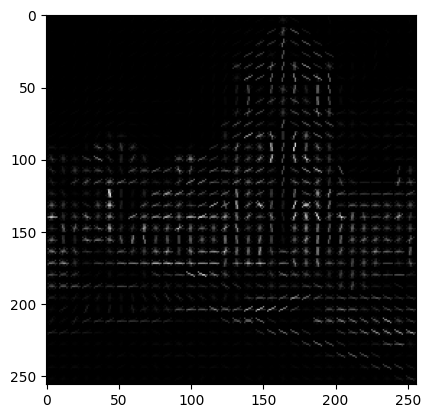

In [ ]:
plt.imshow(hog_image, cmap = 'gray')

In [ ]:
print(features)

[0.24085807 0.12776856 0.24085807 ... 0.34331658 0.04204754 0.06860128]


In [ ]:
# class LSTM_(nn.Module):
#   def __init__(self, embedding_size, hidden_size, num_layers, hog_features , vocab_size):
#     super(LSTM_, self).__init__()

#     self.hidden_size = hidden_size
#     self.num_layers = num_layers

#     self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first = True)

#     self.embedding = nn.Embedding(vocab_size, embedding_size)

#     self.init_h = nn.Linear(hog_features, hidden_size)
#     self.init_c = nn.Linear(hog_features, hidden_size)

#     self.fc_out = nn.Linear(hidden_size, vocab_size)

#   def forward(self, captions, hog_features):
#     embeddings = self.embedding(captions)
#     h0 = self.init_h(hog_features).unsqueeze(0)
#     c0 = self.init_c(hog_features).unsqueeze(0)
#     # Forward propagate LSTM
#     out, _ = self.lstm(captions, (h0, c0))
#     # Predict next states for all time steps
#     out = self.fc_out(out)
#     return out


In [ ]:
features = list()
total_images = dataset['train'].shape
for image in dataset['train'][:30]['image_id']:
  hog_features, _ = extractHogFeatures(f'./train/train/{image}.jpg')
  features.append(hog_features)
  if image % 10 == 0:
    print(f"Image: {image}/{total_images}")

Image: 0/(21367, 2)
Image: 10/(21367, 2)
Image: 20/(21367, 2)


In [ ]:
features_t = np.array(features)
features_t = torch.tensor([features_t], dtype=torch.float32)
features_t.shape

torch.Size([1, 30, 8100])

torch.Size([1, 95256])
A bottle of Château La Fleur Boireau 2006 red wine, showcasing a classic Bordeaux label with elegant design.


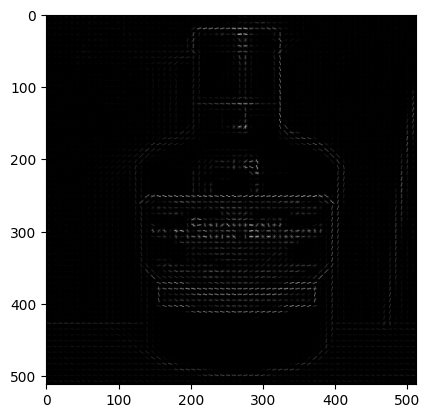

In [ ]:
hog_features, hog_image = extractHogFeatures('./train/train/11.jpg')
hog_features = np.array(hog_features)
hog_features = torch.tensor([hog_features], dtype=torch.float32)
hog_features.shape
print(hog_features.shape)
plt.imshow(hog_image, cmap = 'gray')
print(dataset['train'][11]['caption'])

In [ ]:
tokenizer = Tokenizer(dataset["train"][:1000]["caption"])
input_ids = list()
for caption in dataset['train'][:1000]['caption']:
  i = tokenizer.encode(caption)
  input_ids.append(i)
input_ids = torch.tensor(input_ids)
tensor_ids = torch.tensor(ids).unsqueeze(0)

In [ ]:
tensor_ids.shape

torch.Size([1, 35])

In [ ]:
embedding_dim = 50
hidden_size = 256
vocab_size = tokenizer.vocab_size()
hog_dim = features_t.shape[1]
model = LSTM(embedding_dim, hidden_size, vocab_size, hog_dim)

In [ ]:
criterion = nn.CrossEntropyLoss()
outputs = model(tensor_ids, features_t)
loss = criterion(outputs.view(-1, vocab_size), tensor_ids.view(-1))

IndexError: index out of range in self